# Face Predictions using DeepFace

In [1]:
import itertools
import json
import os
from pathlib import Path
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import pandas as pd

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [2]:
def cv_imshow(image: np.ndarray, ax=plt) -> None:
    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax.axis('off')

def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+height] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

def prompt_extract(path: str) -> str:
    return ' '.join(path.split('_')[1:-1])

In [3]:
def draw_bbox(
    image: np.ndarray,
    bbox: List[int],
    text: Optional[str] = None,
    color: Tuple[int, int, int] = (255,)*3,
    thickness: int = 1,
    fontFace: int = cv.FONT_HERSHEY_SIMPLEX,
    fontScale: float = 0.5
) -> np.ndarray:
    
    cv.rectangle(
        image,
        bbox[:2],
        bbox[2:],
        color=color,
        thickness=thickness
    )
    
    if text:
        (_, h), _ = cv.getTextSize(
            text,
            fontFace=fontFace,
            fontScale=fontScale,
            thickness=thickness
        )
        cv.putText(
            image,
            text,
            (bbox[0], bbox[1]+h),
            fontFace=cv.FONT_HERSHEY_SIMPLEX,
            fontScale=fontScale,
            color=color,
            thickness=thickness
    )   
    
    return image

In [4]:
def image_equalize(
    image: np.ndarray,
    clipLimit: float=2.0,
    grid_size: int = 8
) -> np.ndarray:
    img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    img_l, img_a, img_b = cv.split(img_lab)
    
    clahe = cv.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=(grid_size, grid_size)
    )
    img_l = clahe.apply(img_l)
    
    img_lab = cv.merge((img_l, img_a, img_b))
    img_cl = cv.cvtColor(img_lab, cv.COLOR_LAB2BGR)
    return img_cl

In [5]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

df_actions = (
    'age',
    'gender',
    'race',
    'emotion'
)

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [6]:
def skin_color(
    image: np.ndarray,
    lower_quantile=0.4,
    upper_quantile=0.9
) -> Tuple[Tuple[int, int, int], np.ndarray]:
   
    img_l = cv.cvtColor(image, cv.COLOR_BGR2LAB)[:, :, 0]
    l_lower, l_upper = np.quantile(img_l, [lower_quantile, upper_quantile])
    
    mask = ((img_l >= l_lower) & (img_l <= l_upper))
    blue, green, red = image[mask].mean(axis=0)
    
    return (red, green, blue), mask

In [7]:
def color_show(color: Tuple[int, int, int], size=1, ax=None) -> None:
    color = tuple(c / 256 for c in color)
    rect = matplotlib.patches.Rectangle((0, 0), size, size, color=color)
    if ax is None:
        fig = plt.figure(figsize=(size, size))
        ax = fig.add_subplot(111)
    ax.add_patch(rect)
    ax.axis('off')

In [8]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

all_actions = df_actions + ('skin',)

df_default_models = {
    'age': DeepFace.build_model('Age'),
    'gender': DeepFace.build_model('Gender'),
    'emotion': DeepFace.build_model('Emotion'),
    'race': DeepFace.build_model('Race')
}

def image_predictions(
    image: np.ndarray,
    actions: Tuple[str] = ('gender', 'skin'),
    models: Optional[dict] = None,
    detector_backend: str = 'mtcnn',
    min_size: int = 20,
    equalize: bool = False
) -> Optional[dict]:
    
    assert(all(action in all_actions for action in actions))
    assert(detector_backend in df_backends)
    
    if equalize:
        image = image_equalize(image)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=(a for a in actions if a in df_actions),
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, (a for a in actions if a in df_actions))
        
            if 'skin' in actions:
                color, _ = skin_color(crop_bbox(image, predictions['bbox']))
                predictions['skin color'] = color
    except ValueError:
        pass
        
    return predictions

In [9]:
def quadrant_predictions(
    image: np.ndarray,
    **kwargs: dict,
) -> List[Optional[dict]]:
    
    results = []
    for bbox in quadrant_bboxes(image.shape[:2]):
        img_quadrant = crop_bbox(image, bbox)
        predictions = image_predictions(
            img_quadrant,
            **kwargs
        )
        if predictions:
            predictions['bbox'] = [x + y for x, y in zip(predictions['bbox'], bbox[:2]*2)]
        results.append(predictions)
    return results

In [12]:
images_root = Path('../../images/test')

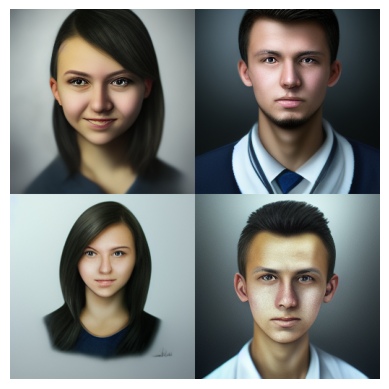

In [13]:
img_path = list(images_root.glob('*.png'))[0]


img_2x2 = cv.imread(str(img_path))
cv_imshow(img_2x2)

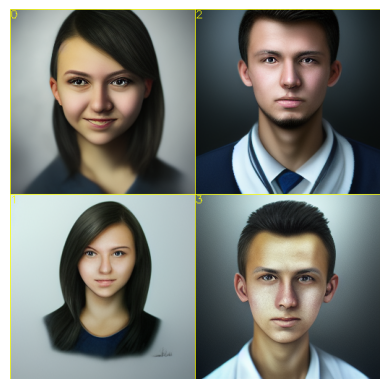

In [14]:
for i, bbox in enumerate(quadrant_bboxes(img_2x2.shape[:2])):
    draw_bbox(img_2x2, bbox, text=f'{i}', color=(0, 255, 255))

cv_imshow(img_2x2)

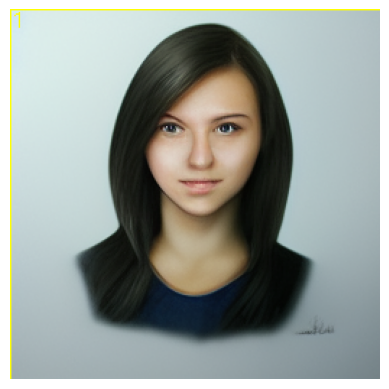

In [15]:
quadrant = 1
img_quad = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[quadrant])
cv_imshow(img_quad)

In [16]:
predictions = quadrant_predictions(img_2x2)
pprint(predictions[quadrant])

1/1 [==============================] - 1s 976ms/step
{'bbox': [97, 298, 171, 400],
 'gender': {'Man': 0.10635777143761516, 'Woman': 99.89364743232727},
 'skin color': (190.0623369848722, 158.48095983307252, 130.52138758476787)}


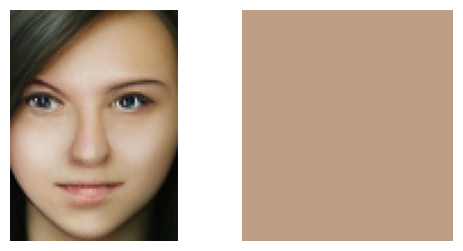

In [17]:
img_face = crop_bbox(img_2x2, predictions[quadrant]['bbox'])
color = predictions[quadrant]['skin color']

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
cv_imshow(img_face, ax=ax[0])
color_show(color, ax=ax[1])

In [18]:
kwargs = {
    'equalize': True,
    'actions': ('gender', 'skin'),
    'models': { 'gender': df_default_models['gender'] },
    'detector_backend': 'mtcnn'
}

all_predictions = []

for quad_path in tqdm(images_root.glob('*.png')):
    quad_image = cv.imread(str(quad_path))
    prompt = prompt_extract(quad_path.stem)
    quad_predictions = [p if p else {} for p in quadrant_predictions(quad_image, **kwargs)]
    for idx, pred in enumerate(quad_predictions):
        pred['image'] = quad_path.stem
        pred['quadrant'] = idx
        pred['prompt'] = prompt
    all_predictions.extend(quad_predictions)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 587ms/step


1it [00:25, 25.85s/it]

1/1 [==============================] - 1s 1s/step


2it [00:50, 24.89s/it]

1/1 [==============================] - 1s 1s/step


3it [01:21, 27.89s/it]

1/1 [==============================] - 1s 803ms/step


4it [01:47, 26.86s/it]


In [20]:
results_df = pd.json_normalize(all_predictions)

lead_cols = [
    'prompt',
    'image',
    'quadrant',
    'bbox'
]

results_df = results_df.reindex(columns=lead_cols+[col for col in results_df.columns if col not in lead_cols])
results_df

,prompt,image,quadrant,bbox,skin color,gender.Woman,gender.Man
0,photo of a student photorealistic headshot,alocasia_photo_of_a_student_photorealistic_hea...,0,"[71, 40, 182, 189]","(190.9892000949442, 158.6316164253501, 128.911...",96.409845,3.590154
1,photo of a student photorealistic headshot,alocasia_photo_of_a_student_photorealistic_hea...,1,"[98, 297, 173, 398]","(197.79198323290544, 167.2302855645795, 138.95...",99.624014,0.375987
2,photo of a student photorealistic headshot,alocasia_photo_of_a_student_photorealistic_hea...,2,"[331, 10, 442, 154]","(191.90841584158414, 155.742698019802, 143.496...",0.062785,99.937218
3,photo of a student photorealistic headshot,alocasia_photo_of_a_student_photorealistic_hea...,3,"[329, 314, 438, 465]","(194.23429398287712, 173.4976486193175, 143.64...",0.145856,99.854147
4,photo of attorney,kylesoto_photo_of_attorney_9ce722a0-6cc2-4b28-...,0,"[80, 41, 167, 154]","(203.4346161595809, 173.26093088857544, 148.62...",0.000027,99.999976
5,photo of attorney,kylesoto_photo_of_attorney_9ce722a0-6cc2-4b28-...,1,"[44, 293, 108, 377]","(206.91272189349112, 166.14423076923077, 69.80...",75.562644,24.437362
6,photo of attorney,kylesoto_photo_of_attorney_9ce722a0-6cc2-4b28-...,2,"[356, 71, 436, 185]","(203.99438444924405, 181.08596112311014, 143.2...",0.000074,99.999928
7,photo of attorney,kylesoto_photo_of_attorney_9ce722a0-6cc2-4b28-...,3,"[256, 288, 347, 422]","(209.44211040547142, 149.33724149161375, 83.62...",0.001816,99.998188
8,photo of a ceo,vroz_photo_of_a_ceo_bf9f768c-295b-453b-8bde-60...,0,"[79, 18, 194, 184]","(162.28496232841366, 160.57601403653626, 148.9...",0.040307,99.959689
9,photo of a ceo,vroz_photo_of_a_ceo_bf9f768c-295b-453b-8bde-60...,1,"[74, 299, 200, 476]","(182.3804882410802, 156.81686488419922, 114.69...",0.000352,99.999642


In [21]:
results_df.to_csv(Path('./results.csv'), index=False)